In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf 
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [3]:
train_dir = "train"
validation_dir = "test"
BATCH_SIZE = 32
IMG_SIZE = (70, 70)

train_dataset = image_dataset_from_directory(
    train_dir, label_mode = 'categorical', shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE
)


validation_dataset = image_dataset_from_directory(
    validation_dir,label_mode = 'categorical', shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE
)


class_names = train_dataset.class_names


Found 6000 files belonging to 5 classes.
Found 2000 files belonging to 5 classes.


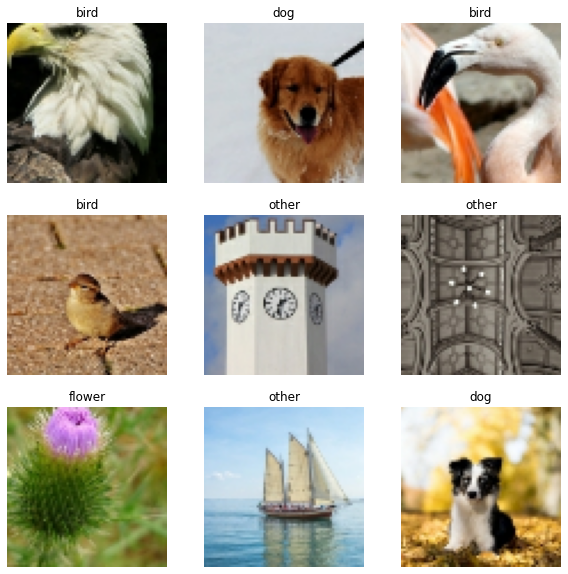

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i].numpy())])
        plt.axis("off")

Number of validation batches: 51
Number of test batches: 12


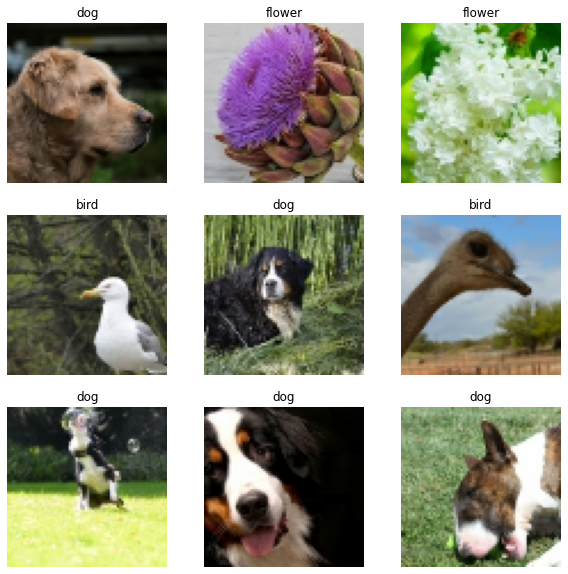

In [5]:

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i].numpy())])
        plt.axis("off")


val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)


print("Number of validation batches: %d" % tf.data.experimental.cardinality(validation_dataset))
print("Number of test batches: %d" % tf.data.experimental.cardinality(test_dataset))


data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
        tf.keras.layers.experimental.preprocessing.RandomContrast(0.5)
    ]
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 3, 3, 1280)


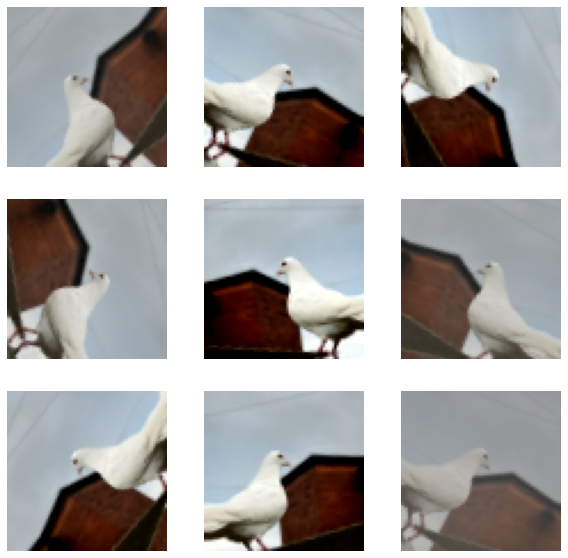

In [6]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis("off")

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 127.5, offset=-1)

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

base_model.trainable = False


In [22]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

base_model.trainable = False

(32, 3, 3, 1280)


In [23]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 70, 70, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 35, 35, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 35, 35, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 35, 35, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [10]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(len(class_names))
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

inputs = tf.keras.Input(shape=(70, 70, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
model.summary()
len(model.trainable_variables)

(32, 1280)
(32, 5)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 70, 70, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 70, 70, 3)         0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 70, 70, 3)         0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 70, 70, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280) 

C:\Users\joel\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


2

In [25]:

initial_epochs = 30

loss0, accuracy0 = model.evaluate(validation_dataset)


print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


history = model.fit(train_dataset, epochs=initial_epochs, validation_data=validation_dataset)


acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()), 1])
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.ylim([0, 1.0])
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()


base_model.trainable = True


print("Number of layers in the base model: ", len(base_model.layers))


fine_tune_at = 100


for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate / 10),
    metrics=["accuracy"],
)

51/51 [==============================] - 23s 416ms/step - loss: 3.9778 - accuracy: 0.1813
initial loss: 3.98
initial accuracy: 0.18
Epoch 1/30
188/188 [==============================] - 94s 486ms/step - loss: 2.4565 - accuracy: 0.2838 - val_loss: 1.4344 - val_accuracy: 0.4821
Epoch 2/30
188/188 [==============================] - 31s 166ms/step - loss: 1.4374 - accuracy: 0.5010 - val_loss: 0.8910 - val_accuracy: 0.6782
Epoch 3/30
188/188 [==============================] - 31s 167ms/step - loss: 1.1117 - accuracy: 0.6092 - val_loss: 0.7018 - val_accuracy: 0.7426
Epoch 4/30
188/188 [==============================] - 30s 160ms/step - loss: 1.0106 - accuracy: 0.6487 - val_loss: 0.6229 - val_accuracy: 0.7791
Epoch 5/30
188/188 [==============================] - 31s 163ms/step - loss: 0.9345 - accuracy: 0.6768 - val_loss: 0.5641 - val_accuracy: 0.7915
Epoch 6/30
188/188 [==============================] - 30s 161ms/step - loss: 0.8555 - accuracy: 0.7020 - val_loss: 0.5362 - val_accuracy: 0.805

KeyboardInterrupt: 

In [ ]:
class_names

In [ ]:
model.summary()

In [ ]:
len(model.trainable_variables)
fine_tune_epochs = 40
total_epochs = initial_epochs + fine_tune_epochs

In [ ]:

history_fine = model.fit(
    train_dataset, epochs=total_epochs, initial_epoch=history.epoch[-1], validation_data=validation_dataset
)

In [ ]:

acc += history_fine.history["accuracy"]
val_acc += history_fine.history["val_accuracy"]

loss += history_fine.history["loss"]
val_loss += history_fine.history["val_loss"]


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.ylim([0.8, 1])
plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label="Start Fine Tuning")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.ylim([0, 1.0])
plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label="Start Fine Tuning")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print("Test accuracy :", accuracy)


image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()


predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print("Predictions:\n", predictions.numpy())
print("Labels:\n", label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")



In [19]:
pred_vec = model.predict(image_batch.numpy()[[0]])

In [20]:
np.argmax(pred_vec)

0

In [21]:
class_names[np.argmax(pred_vec)]

'berry'

In [22]:
model.save('picture')

KeyboardInterrupt: 

In [5]:
model_model = tf.keras.models.load_model('picture')
mdl = model()

NameError: name 'model' is not defined

In [ ]:
image_batch.numpy()[[0]].shape

In [ ]:
image_batch.numpy()

In [ ]:
e = model_model.predict(image_batch.numpy()[[0]])

In [ ]:
class_names[np.argmax(e)]

In [ ]:
image_batch.numpy()[[0]].shape

In [ ]:
pred_vec
e = model_model.predict(image_batch.numpy()[[0]])
class_names[np.argmax(e)]

In [ ]:
import os 
class_names = os.listdir('train')
from tensorflow.keras.models import load_model
class model:
    def __init__(self):
        self.model = load_model('picture')
    def predict(self, img):
        pred_vec = self.model.predict(img)
        return class_names[np.argmax(pred_vec)]

In [ ]:
class_names

In [ ]:
pred_vec = mdl.model.predict(image_batch.numpy()[[0]])

In [ ]:
class_names[np.argmax(pred_vec)]

In [ ]:
mdl.predict(image_batch.numpy()[[0]])

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf 
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
def train_model(image_directory = 'images', training_epochs = 15, fine_tune_epochs = 15 ):
    mdl = 